In [1]:
import pandas as pd
import numpy as np
import pickle
from pprint import pprint
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaModel
from gensim.test.utils import datapath

/usr/local/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# load data
dictionary = Dictionary.load("data/dictionary.pkl")
downsamp_out = pd.read_csv("data/down_genre_reviews.tsv", sep="\t", names=["doc_id","genre","tokens"])
train_reviews = downsamp_out["tokens"].apply(lambda tok: tok.split()).tolist()
train_corpus = [dictionary.doc2bow(rev) for rev in train_reviews]

### Authorless

In [3]:
# load best model (20 topics)
lda = LdaModel.load(datapath("authorless_20"))

In [4]:
# learned topic proportion prior
lda.alpha

array([0.0556201 , 0.03930655, 0.06767023, 0.1286734 , 0.03916504,
       0.05491321, 0.08559053, 0.07674429, 0.05064195, 0.05676996,
       0.04318236, 0.04992571, 0.07237544, 0.03805463, 0.07743497,
       0.05502876, 0.08167285, 0.05626325, 0.04170714, 0.06623422],
      dtype=float32)

In [5]:
# track topic proportions and counts by genre and rating
genre_props = np.zeros((3,20))
genre_counts = np.zeros((3,20))

genre_dict = {
    "fantasy": 0,
    "history": 1,
    "mystery": 2
}

# and find representative documents for each topic (max prop)
topic_doc_dict = {
    0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[],
    10:[], 11:[], 12:[], 13:[], 14:[], 15:[], 16:[], 17:[], 18:[], 19:[],
}

# gather above info for each doc
for i, doc in enumerate(train_corpus):
    doc_genre = downsamp_out.loc[i,"genre"]
    topic_props = lda.get_document_topics(doc, minimum_probability=0.01)
    doc_max_prop = (0,0)
    for top in topic_props:
        genre_props[genre_dict[doc_genre],top[0]] += top[1]
        genre_counts[genre_dict[doc_genre],top[0]] += 1
        # track topic with max proportion in document
        if top[1] > doc_max_prop[1]:
            doc_max_prop = top
    # add doc to dict for topic of max proportion
    topic_doc_dict[doc_max_prop[0]].append((i,doc_max_prop[1]))

In [6]:
# average topics per review
genre_counts.sum()/len(train_corpus)

4.864744687830302

In [9]:
# average topics per review by genre
genre_counts.sum(1)/downsamp_out.groupby("genre").count()["doc_id"].to_numpy()

array([4.86567438, 4.87750065, 4.84906915])

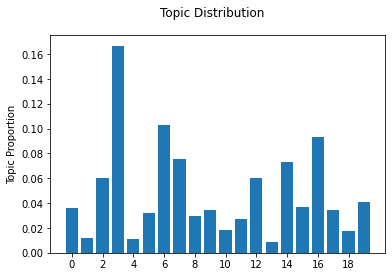

In [10]:
# overall topic distribution
topic_props = genre_props.sum(0)/len(train_corpus)
fig, ax = plt.subplots()
fig.suptitle("Topic Distribution")
ax.bar(np.arange(20),topic_props)
ax.set_xticks(np.arange(0,20,2))
ax.set_ylabel("Topic Proportion")
plt.show()

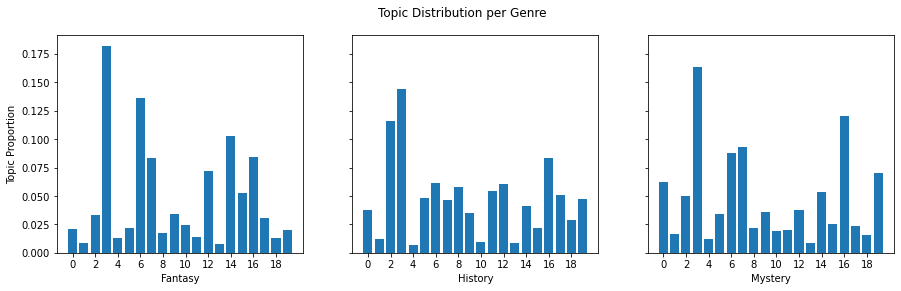

In [13]:
# per genre topic distribution
per_genre_props = np.divide(genre_props,downsamp_out.groupby("genre").count()["doc_id"].to_numpy()[:,np.newaxis])
fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,4))
fig.suptitle("Topic Distribution per Genre")
ax[0].set_xlabel("Fantasy")
ax[0].bar(np.arange(20),per_genre_props[0])
ax[0].set_xticks(np.arange(0,20,2))
ax[0].set_ylabel("Topic Proportion")
ax[1].set_xlabel("History")
ax[1].bar(np.arange(20),per_genre_props[1])
ax[1].set_xticks(np.arange(0,20,2))
ax[2].set_xlabel("Mystery")
ax[2].bar(np.arange(20),per_genre_props[2])
ax[2].set_xticks(np.arange(0,20,2))
plt.show()

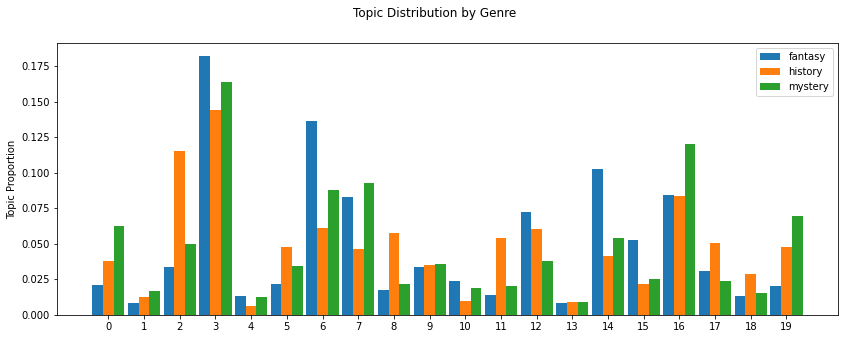

In [14]:
fig, ax = plt.subplots(figsize=(14,5))
width = 0.3
fig.suptitle("Topic Distribution by Genre")
ax.bar(np.arange(20)-width,per_genre_props[0],width,label="fantasy")
ax.bar(np.arange(20),per_genre_props[1],width,label="history")
ax.bar(np.arange(20)+width,per_genre_props[2],width,label="mystery")
ax.set_xticks(np.arange(20))
ax.set_ylabel("Topic Proportion")
plt.legend()
plt.show()

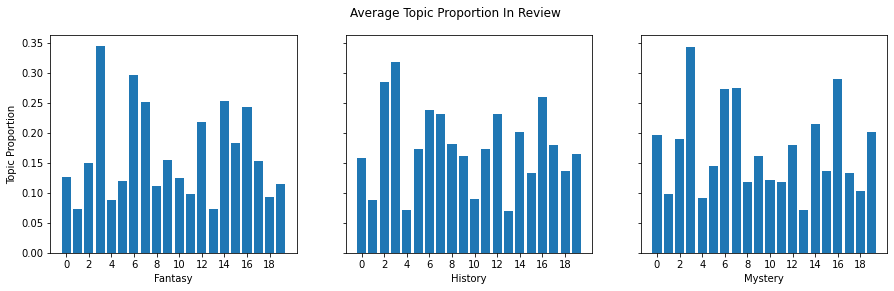

In [15]:
# avg topic proportion when present in a review (so shouldn't sum to 1)
genre_avg_props = np.divide(genre_props,genre_counts,out=np.zeros((3,20)),where=genre_counts!=0)
fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,4))
fig.suptitle("Average Topic Proportion In Review")
ax[0].set_xlabel("Fantasy")
ax[0].bar(np.arange(20),genre_avg_props[0])
ax[0].set_xticks(np.arange(0,20,2))
ax[0].set_ylabel("Topic Proportion")
ax[1].set_xlabel("History")
ax[1].bar(np.arange(20),genre_avg_props[1])
ax[1].set_xticks(np.arange(0,20,2))
ax[2].set_xlabel("Mystery")
ax[2].bar(np.arange(20),genre_avg_props[2])
ax[2].set_xticks(np.arange(0,20,2))
plt.show()

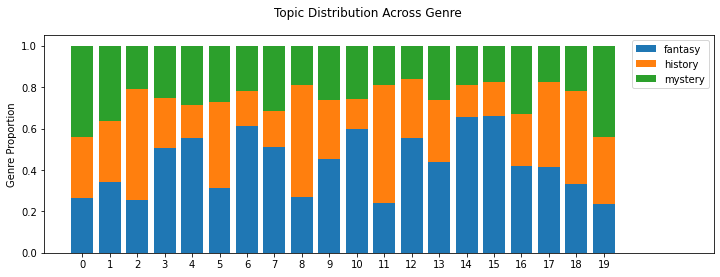

In [16]:
# topic distribution across genre
topic_genre_props = pd.DataFrame((genre_props/genre_props.sum(0)).T,columns=["fantasy","history","mystery"])
fig, ax = plt.subplots(figsize=(12,4))
fig.suptitle("Topic Distribution Across Genre")
ax.bar(np.arange(20),topic_genre_props["fantasy"],label="fantasy")
ax.bar(np.arange(20),topic_genre_props["history"],label="history",bottom=topic_genre_props["fantasy"])
ax.bar(np.arange(20),topic_genre_props["mystery"],label="mystery",bottom=topic_genre_props["fantasy"]+topic_genre_props["history"])
ax.set_xticks(np.arange(20))
ax.set_xlim(None,23)
ax.set_ylabel("Genre Proportion")
ax.legend()
plt.show()

In [17]:
pprint(lda.print_topics(num_words=20))

[(0,
  '0.011*"year" + 0.009*"new" + 0.008*"find" + 0.007*"life" + 0.007*"old" + '
  '0.007*"town" + 0.007*"time" + 0.007*"house" + 0.007*"family" + '
  '0.006*"friend" + 0.005*"home" + 0.005*"girl" + 0.005*"mystery" + '
  '0.004*"mother" + 0.004*"father" + 0.004*"murder" + 0.004*"get" + '
  '0.004*"man" + 0.004*"back" + 0.004*"york"'),
 (1,
  '0.016*"alert" + 0.015*"jane" + 0.015*"spoiler" + 0.015*"spoiler_alert" + '
  '0.011*"grace" + 0.011*"anna" + 0.008*"david" + 0.008*"life" + '
  '0.007*"hannah" + 0.006*"julia" + 0.006*"husband" + 0.006*"amy" + '
  '0.005*"back" + 0.005*"agatha" + 0.005*"reader" + 0.004*"year" + 0.004*"dog" '
  '+ 0.004*"two" + 0.004*"brown" + 0.004*"christie"'),
 (2,
  '0.007*"war" + 0.007*"world" + 0.006*"time" + 0.005*"well" + 0.005*"also" + '
  '0.005*"would" + 0.005*"good" + 0.005*"people" + 0.004*"many" + '
  '0.004*"history" + 0.004*"much" + 0.004*"even" + 0.004*"work" + '
  '0.004*"interesting" + 0.003*"way" + 0.003*"reader" + 0.003*"make" + '
  '0.003*"p

In [18]:
# representative reviews for each topic
for i in range(20):
    print("\nTOPIC ",i)
    topic_doc_dict[i].sort(key = lambda x: x[1], reverse=True)
    for j in range(3):
        if len(topic_doc_dict[i])>j:
            print(topic_doc_dict[i][j])
            print(downsamp_out.loc[topic_doc_dict[i][j][0],"tokens"])


TOPIC  0
(781, 0.96642303)
another solid legal thriller married criminal defense attorney guilty pleasure wish spouse taken anyhow disturbed image lincoln lawyer movie casting matthew mickey ouch way keep vivid image character perceive written legal_thriller defense_attorney guilty_pleasure mickey_haller
(40270, 0.94434464)
keep sleuthing skill sharp solve yet another murder excellent series time sister asks find whodunit meantime continue learn character yet_another
(74392, 0.9443337)
best long time someone trying destroy newly built brooklyn bridge always step ahead law great title bridge also long_time step_ahead

TOPIC  1
(2723, 0.94076467)
stream conscious compelling often wondered would like le family member extremist fear confirmed short direct truth poignant parent child
(3779, 0.9304598)
yep another dan brown tale twist near end made great job dan thanks dan_brown near_end great_job
(8660, 0.9158198)
excellent romance chase lost job make matter worse new neighbour appears ins

In [19]:
# load best model (50 topics)
lda = LdaModel.load(datapath("authorless_50"))

In [20]:
pprint(lda.print_topics(num_topics=50,num_words=20))

[(0,
  '0.022*"new" + 0.013*"york" + 0.013*"new_york" + 0.012*"city" + 0.009*"time" '
  '+ 0.007*"life" + 0.006*"amelia" + 0.006*"work" + 0.005*"lisa" + '
  '0.005*"many" + 0.005*"year" + 0.005*"history" + 0.005*"college" + '
  '0.004*"research" + 0.004*"orleans" + 0.004*"legal" + 0.004*"new_orleans" + '
  '0.004*"author" + 0.004*"like" + 0.004*"also"'),
 (1,
  '0.039*"short" + 0.020*"short_story" + 0.015*"collection" + 0.014*"rose" + '
  '0.014*"grace" + 0.010*"dog" + 0.010*"music" + 0.009*"art" + 0.009*"robin" + '
  '0.007*"animal" + 0.007*"tale" + 0.007*"life" + 0.006*"work" + '
  '0.006*"written" + 0.006*"gaiman" + 0.005*"neil" + 0.005*"song" + '
  '0.005*"part" + 0.005*"section" + 0.004*"reader"'),
 (2,
  '0.008*"world" + 0.006*"time" + 0.006*"people" + 0.005*"would" + '
  '0.005*"also" + 0.005*"well" + 0.005*"even" + 0.004*"much" + 0.004*"make" + '
  '0.004*"point" + 0.004*"good" + 0.004*"work" + 0.004*"reader" + 0.004*"many" '
  '+ 0.004*"fact" + 0.004*"rather" + 0.003*"way" + 0